# Imports

## Libraries

In [106]:
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import warnings
warnings.filterwarnings('ignore')
from shapely.geometry import Point

## Data

In [107]:
provinces_gdf = gpd.read_file("../data/provinces_gdf.geojson", driver='geojson')

# Centroids

## Calculate centroid for each region in italy 

There are *two* centroids I'll be plotting: one is a **geographic centroid** which is the true center of a regional unit. The other is a **"weighted mean population centroid,"** which shows the center of the *population* in a regional unit. 

- Steps to getting the population weighted mean centroid
    - find geographic centroid for each province 
    - group the provinces into a larger unit (macroregion, cultural region, all of italy)
    - assign a weight (i.e.: the population) to each province
    - find the numerator: multiply each latitude and longitude by the weight 
    - find the denominator: multiply a weight by the number of units in the smaller geometry
    - sum up all of the numerators and denominators for a given regional unit
    - divide the numerator by the denominator
    - plot results next to the geographic centroid

## Regions

### Getting Region Geometries

In [108]:
region_gemoetries = provinces_gdf.dissolve(by='Region')

### Finding Geographic centroid

In [109]:
# combining the data by region and then finding the centroid of that combined geometry
region_geo_centroids = provinces_gdf.dissolve(by='Region')
region_geo_centroids['geometry'] = region_geo_centroids['geometry'].centroid

### Getting Weighted population centroids

In [110]:
# finding sum of population for each region
region_pop_sum = provinces_gdf.groupby('Region').Population.sum()

In [111]:
# finding weighted lat and lon for each region
provinces_gdf['Weighted_region_centroid_lat'] = [provinces_gdf['Pop_weighted_lat'][x] / \
                                                 region_pop_sum[provinces_gdf['Region'][x]] 
                                                for x in range(len(provinces_gdf))]
provinces_gdf['Weighted_region_centroid_lon'] = [provinces_gdf['Pop_weighted_lon'][x] / \
                                                 region_pop_sum[provinces_gdf['Region'][x]] 
                                                for x in range(len(provinces_gdf))]

In [112]:
# sum up all of the weighted coords and recombine
region_coord_sum = provinces_gdf.groupby('Region') \
                    ['Weighted_region_centroid_lat','Weighted_region_centroid_lon'].sum()

region_coord_sum['Weighted_centroid_coords'] = list(zip(region_coord_sum['Weighted_region_centroid_lat'], 
                                                   region_coord_sum['Weighted_region_centroid_lon']))
region_coord_sum['geometry'] = [Point(x) for x in region_coord_sum['Weighted_centroid_coords']]

In [113]:
# making it into a geodataframe
region_pop_weighted_gdf = gpd.GeoDataFrame(region_coord_sum)

### Plot 

<AxesSubplot:>

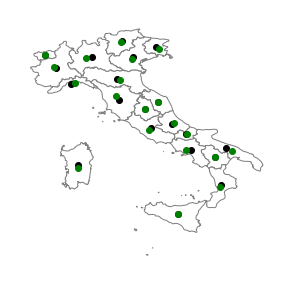

In [143]:
# green is population center while black is geo center
ax1 = region_geo_centroids.plot(color='black', figsize=(5,5))
region_pop_weighted_gdf.plot(figsize=(5,5), ax=ax1, color='green')
gplt.polyplot(region_gemoetries, facecolor='white', edgecolor='grey', ax=ax1, figsize=(5,5))

### Which regional centers are furthest/closest to the geographic center?

**SMALLEST DISTANCE**: Aosta Valley (upper left-most region) has the lowest distance between centroids since it has only one province in the region

In [115]:
# finding largest distance
region_pop_weighted_gdf['Geographic_centroid'] = region_geo_centroids.geometry
region_pop_weighted_gdf['Distance_bn_centroids'] = region_pop_weighted_gdf.geometry.distance(
    region_pop_weighted_gdf['Geographic_centroid'])
max_distance = region_pop_weighted_gdf['Distance_bn_centroids'].max()
region_pop_weighted_gdf[region_pop_weighted_gdf['Distance_bn_centroids'] == max_distance]

,Weighted_region_centroid_lat,Weighted_region_centroid_lon,Weighted_centroid_coords,geometry,Geographic_centroid,Distance_bn_centroids
Region,,,,,,
Apulia,16.949857,40.812992,"(16.94985665711923, 40.8129922094144)",POINT (16.94986 40.81299),POINT (16.62105 40.98575),0.37143


**LARGEST DISTANCE**: Apulia (lower right-most region) has the furthest distance between centroids.

## Macroregions

### Getting Macroregion Geometries

In [116]:
macroregion_gemoetries = provinces_gdf.dissolve(by='Macroregion')

### Finding Geographic Centroids

In [117]:
macroregion_geo_centroids = provinces_gdf.dissolve(by='Macroregion')
macroregion_geo_centroids['geometry'] = macroregion_geo_centroids['geometry'].centroid

### Getting Weighted Population Centroids

In [118]:
# finding sum of population for each region
macroregion_pop_sum = provinces_gdf.groupby('Macroregion').Population.sum()

In [119]:
# finding weighted lat and lon for each region
provinces_gdf['Weighted_macroregion_centroid_lat'] = [provinces_gdf['Pop_weighted_lat'][x] / \
                                                 macroregion_pop_sum[provinces_gdf['Macroregion'][x]] 
                                                for x in range(len(provinces_gdf))]
provinces_gdf['Weighted_macroregion_centroid_lon'] = [provinces_gdf['Pop_weighted_lon'][x] / \
                                                 macroregion_pop_sum[provinces_gdf['Macroregion'][x]] 
                                                for x in range(len(provinces_gdf))]

In [120]:
# sum up all of the weighted coords and recombine
macroregion_coord_sum = provinces_gdf.groupby('Macroregion') \
                    ['Weighted_macroregion_centroid_lat','Weighted_macroregion_centroid_lon'].sum()
macroregion_coord_sum['Weighted_centroid_coords'] = list(zip(
                                                    macroregion_coord_sum['Weighted_macroregion_centroid_lat'], 
                                                   macroregion_coord_sum['Weighted_macroregion_centroid_lon']))
macroregion_coord_sum['geometry'] = [Point(x) for x in macroregion_coord_sum['Weighted_centroid_coords']]

In [121]:
# making it into a geodataframe
macroregion_pop_weighted_gdf = gpd.GeoDataFrame(macroregion_coord_sum)

### Plot

<AxesSubplot:>

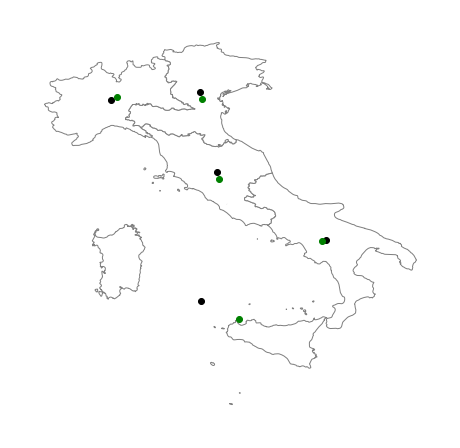

In [122]:
# green is population center while black is geo center
ax2 = macroregion_geo_centroids.plot(color='black', figsize=(8,8))
macroregion_pop_weighted_gdf.plot(figsize=(8,8), ax=ax2, color='green')
gplt.polyplot(macroregion_gemoetries, facecolor='white', edgecolor='grey', ax=ax2, figsize=(8,8))

## Cultural Regions

### Getting Cultural Geometries

In [123]:
cultural_region_geometries = provinces_gdf.dissolve(by='Cultural_region')

### Finding Geographic Centroids

In [124]:
cultural_region_centroids = provinces_gdf.dissolve(by='Cultural_region')
cultural_region_centroids['geometry'] = cultural_region_centroids['geometry'].centroid

### Getting Weighted Population Centroids

In [125]:
# finding sum of population for each region
cultural_region_pop_sum = provinces_gdf.groupby('Cultural_region').Population.sum()

In [126]:
# finding weighted lat and lon for each region
provinces_gdf['Weighted_cult_region_centroid_lat'] = [provinces_gdf['Pop_weighted_lat'][x] / \
                                                 cultural_region_pop_sum[provinces_gdf['Cultural_region'][x]] 
                                                for x in range(len(provinces_gdf))]
provinces_gdf['Weighted_cult_region_centroid_lon'] = [provinces_gdf['Pop_weighted_lon'][x] / \
                                                 cultural_region_pop_sum[provinces_gdf['Cultural_region'][x]] 
                                                for x in range(len(provinces_gdf))]

In [127]:
# sum up all of the weighted coords and recombine
cult_region_coord_sum = provinces_gdf.groupby('Cultural_region') \
                    ['Weighted_cult_region_centroid_lat','Weighted_cult_region_centroid_lon'].sum()
cult_region_coord_sum['Weighted_centroid_coords'] = list(zip(
                                                    cult_region_coord_sum['Weighted_cult_region_centroid_lat'], 
                                                   cult_region_coord_sum['Weighted_cult_region_centroid_lon']))
cult_region_coord_sum['geometry'] = [Point(x) for x in cult_region_coord_sum['Weighted_centroid_coords']]

In [128]:
# making it into a geodataframe
cult_region_pop_weighted_gdf = gpd.GeoDataFrame(cult_region_coord_sum)

### Plot

<AxesSubplot:>

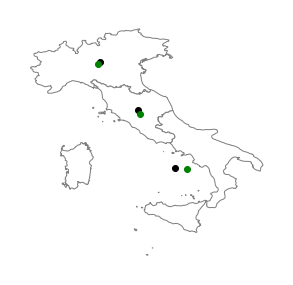

In [142]:
# green is population center while black is geo center
ax3 = cultural_region_centroids.plot(color='black', figsize=(5,5))
cult_region_pop_weighted_gdf.plot(figsize=(5,5), ax=ax3, color='green')
gplt.polyplot(cultural_region_geometries, facecolor='white', edgecolor='grey', ax=ax3, figsize=(5,5))

## All of Italy

### Getting Italy's Geometry

In [130]:
italy_geometry = provinces_gdf.dissolve(by='Country')

### Finding Geographic Centroids

In [131]:
italy_centroid = provinces_gdf.dissolve(by='Country')
italy_centroid['geometry'] = italy_centroid['geometry'].centroid

### Getting Weighted Population Centroids

In [132]:
# finding sum of population for each region
italy_pop_sum = provinces_gdf.groupby('Country').Population.sum()

In [133]:
# finding weighted lat and lon for each region
provinces_gdf['Weighted_country_centroid_lat'] = [provinces_gdf['Pop_weighted_lat'][x] / \
                                                 italy_pop_sum[provinces_gdf['Country'][x]] 
                                                for x in range(len(provinces_gdf))]
provinces_gdf['Weighted_country_centroid_lon'] = [provinces_gdf['Pop_weighted_lon'][x] / \
                                                 italy_pop_sum[provinces_gdf['Country'][x]] 
                                                for x in range(len(provinces_gdf))]

In [134]:
# sum up all of the weighted coords and recombine
country_coord_sum = provinces_gdf.groupby('Country') \
                    ['Weighted_country_centroid_lat','Weighted_country_centroid_lon'].sum()
country_coord_sum['Weighted_centroid_coords'] = list(zip(
                                                    country_coord_sum['Weighted_country_centroid_lat'], 
                                                   country_coord_sum['Weighted_country_centroid_lon']))
country_coord_sum['geometry'] = [Point(x) for x in country_coord_sum['Weighted_centroid_coords']]

In [135]:
# making it into a geodataframe
country_pop_weighted_gdf = gpd.GeoDataFrame(country_coord_sum)

In [136]:
country_pop_weighted_gdf

,Weighted_country_centroid_lat,Weighted_country_centroid_lon,Weighted_centroid_coords,geometry
Country,,,,
Italy,12.061933,42.939056,"(12.06193324270437, 42.939055815900794)",POINT (12.06193 42.93906)


### Plot

In [137]:
italy_centroid

,geometry,Code,name,Province,Region,Macroregion,Population,Area,Density,Cultural_region,Pop_weighted_lat,Pop_weighted_lon,Weighted_region_centroid_lat,Weighted_region_centroid_lon,Weighted_macroregion_centroid_lat,Weighted_macroregion_centroid_lon,Weighted_cult_region_centroid_lat,Weighted_cult_region_centroid_lon
Country,,,,,,,,,,,,,,,,,,
Italy,POINT (12.07191 42.78643),AG,Agrigento,Agrigento,Sicily,Insular,434870,3053,144,South,5.872772e+06,1.627845e+07,1.17458,3.255761,0.866149,2.400835,0.283185,0.784947


<AxesSubplot:>

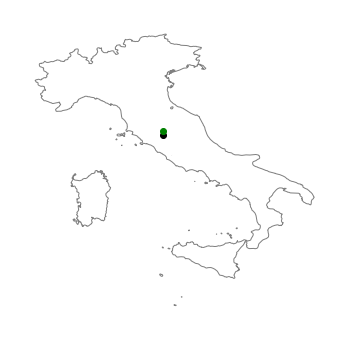

In [141]:
# green is population center while black is geo center
ax4 = italy_centroid.plot(color='black', figsize=(5,5))
country_pop_weighted_gdf.plot(figsize=(5,5), ax=ax4, color='green')
gplt.polyplot(italy_geometry, facecolor='white', edgecolor='grey', ax=ax4, figsize=(5,5))